# DCS Parametric Python Truss Example
Example of Python project implementing the Two-Bar Truss example from  R.L. Fox, Optimization Methods in Engineering Design, Addison Wesley, 1971 See e.g. https://static1.squarespace.com/static/53eacd17e4b0588f78eb723c/t/586ea636d482e91c7a76bd61/1483646550748/Optimization+Methods+in+Engineering+Design.pdf 

In [1]:
import os
import random
import sys
import time

from ansys.rep.client import DCSError
from ansys.rep.client.jms import (Client, JobDefinition, Job, File,
                                  FitnessDefinition, Project)

### Connect to DCS Services

In [2]:
client = Client(rep_url="https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com/dcs", username="demo", password="tnz")
print(client.rep_url)

https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com/dcs


### Create DCS project

In [3]:
# Create project
proj = Project(id="two_bar_truss_problem", display_name="Two-bar Truss Problem", priority=1, active=True)
proj = client.create_project(proj, replace=True)
print(f"Project created: {proj.id}")

Project created: two_bar_truss_problem


In [4]:
# Define Files
files=[]    
files.append (File( name="input_params",evaluation_path="input_parameters.json",
                    type="text/plain", src="input_parameters.json" ) )
files.append (File( name="pyscript",evaluation_path="evaluate.py",
                    type="text/plain", src="evaluate.py" ) )
files.append( File( name="results", evaluation_path="output_parameters.json", type="text/plain", collect=True ) )

files = proj.create_files(files)
print(f"Files created: {[f.id for f in files]}")

input_file=files[0]
result_file=files[2]

Files created: [1, 2, 3]


In [5]:
# JobDefinition with simulation workflow and parameters
job_def = JobDefinition(name="job_definition.1", active=True, )

# Input params
pd = job_def.add_float_parameter_definition(name='height', lower_limit=10, upper_limit=100.0, default=30, units="in" )
job_def.add_parameter_mapping(key_string='"H"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

pd = job_def.add_float_parameter_definition(name='diameter', lower_limit=0.2, upper_limit=5, default=3, units="in" )
job_def.add_parameter_mapping(key_string='"d"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

pd = job_def.add_float_parameter_definition(name='thickness', lower_limit=0.03, upper_limit=0.6, default=0.15, units="in")
job_def.add_parameter_mapping(key_string='"t"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

pd = job_def.add_float_parameter_definition(name='separation_distance', lower_limit=40, upper_limit=150, default=60, units="in" )
job_def.add_parameter_mapping(key_string='"B"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

pd = job_def.add_float_parameter_definition(name='young_modulus', lower_limit=1E+6, upper_limit=1E+8, default=3E+7, units="lbs in^-2" )
job_def.add_parameter_mapping(key_string='"E"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

pd = job_def.add_float_parameter_definition(name='density', lower_limit=0.1, upper_limit=0.6, default=0.3, units="lbs in^-2" )
job_def.add_parameter_mapping(key_string='"rho"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

pd = job_def.add_float_parameter_definition(name='load', lower_limit=1E+1, upper_limit=1E+5, default=66E+3, units="lbs" )
job_def.add_parameter_mapping(key_string='"P"', tokenizer=":", parameter_definition_name=pd.name, file_id=input_file.id)

out_params = {"weight":"lbs", "stress":"ksi", "buckling_stress":"ksi", "deflection":"in"}
for pname, unit in out_params.items():
    pd = job_def.add_float_parameter_definition(name=pname, units=unit)
    job_def.add_parameter_mapping(key_string=f'"{pname}"', tokenizer=":", parameter_definition_name=pd.name, file_id=result_file.id)

# Process step
job_def.add_task_definition(   name="python_evaluation", 
                        application_name="Python",
                        application_version="3.6",
                        execution_command='%executable% %file:pyscript% %file:input_params%',
                        max_execution_time=30.0,
                        cpu_core_usage=0.5,
                        execution_level=0,
                        memory=100,
                        disk_space=5,
                        input_file_ids=[f.id for f in files[:2]], 
                        output_file_ids=[f.id for f in files[2:]] 
                    )

# Fitness definition
fd = FitnessDefinition(error_fitness=10.0)
fd.add_fitness_term(name="weight", type="design_objective", weighting_factor=1.0,
                    expression="map_design_objective( values['weight'], 35, 20)")
fd.add_fitness_term(name="max_stress", type="limit_constraint", weighting_factor=1.0,
                expression="map_limit_constraint( values['stress'], 85, 10 )") 
fd.add_fitness_term(name="max_deflection", type="limit_constraint", weighting_factor=1.0,
                expression="map_limit_constraint( values['deflection'], 0.25, 0.05 )") 
job_def.fitness_definition =fd

# Create job_definition in project
job_def = proj.create_job_definitions([job_def])[0]

 ### Create design points

In [6]:
dps=[]
for i in range(1000):
    values = { p.name : p.lower_limit + random.random()*(p.upper_limit-p.lower_limit)  for p in job_def.parameter_definitions if p.mode == 'input' }
    dps.append( Job( name=f"Job.{i}", values=values, eval_status="pending") )
dps=job_def.create_jobs(dps)

### Wait for the first 50 design points to be evaluated

In [13]:
dps=[]
while len(dps)<50:
    dps=job_def.get_jobs(eval_status='evaluated')
    print(f"Number of evaluated design points: {len(dps)}")
    time.sleep(5)


Number of evaluated design points: 448


In [14]:
# Extract parameter values into Pandas dataframe
values = {}
for param_name,value in dps[0].values.items():
    print(f"param: {param_name}")
    param_values = [ dp.values[param_name] for dp in dps ]
    values[param_name]= param_values
values['fitness'] = [ dp.fitness for dp in dps ]
import pandas as pd
df= pd.DataFrame(values)
#print("---")
#print(df)

param: height
param: diameter
param: thickness
param: separation_distance
param: young_modulus
param: density
param: load
param: weight
param: stress
param: buckling_stress
param: deflection


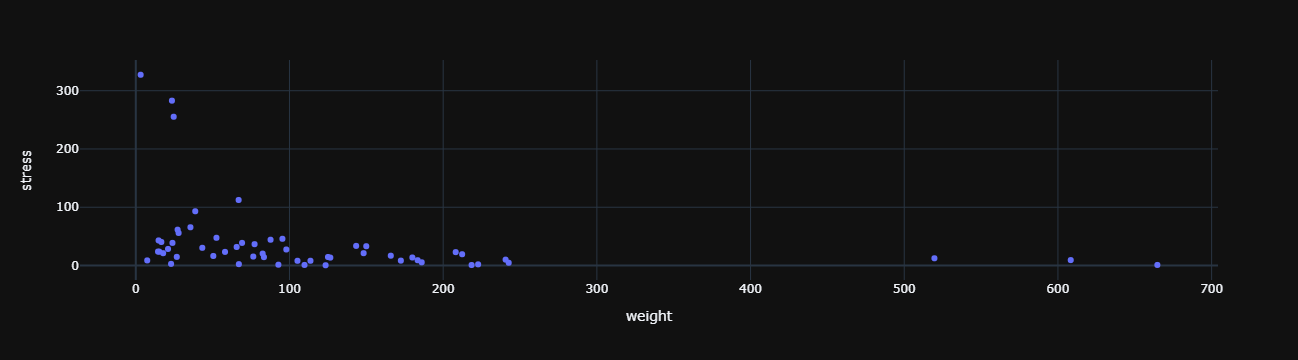

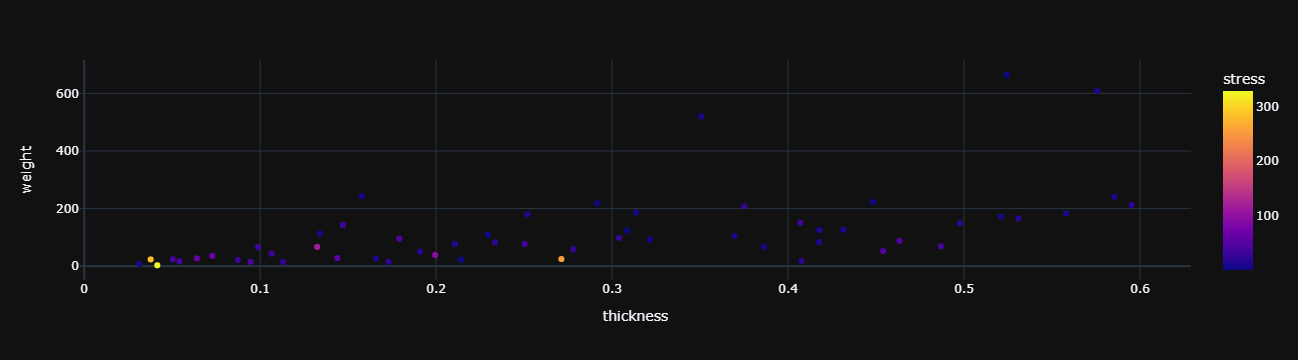

In [12]:
# Plot
import plotly.express as px
fig1 = px.scatter(df, x='weight', y='stress',  template="plotly_dark")
fig1.show()
fig2 = px.scatter(df, x='thickness', y='weight', color='stress', template="plotly_dark")
fig2.show()
